# Import All Important Modules

In [1]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from joblib import dump, load 
from scipy.sparse import save_npz, load_npz 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
from pprint import pprint
import pandas as pd
import string
import os
import re


import numpy as np

# Sentiment Analysis

In [2]:
cleantweets_df = pd.read_csv("../data/processed_data_tweets.csv")
cleantweets_df.head()

,created_at,source,original_text,clean_text,polarity,subjectivity,sentiment,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,2022-04-22 22:17:05+00:00,Twitter for Android,RT @NorthstarCharts: The 10-year yield is tell...,RT @NorthstarCharts The 10year yield is tellin...,0.16,0.540000,positive,en,12179,43,davideiacovozzi,18,55,not_found,gold___silver___crypto___,NorthstarCharts___,not_known
1,2022-04-22 13:44:53+00:00,Twitter for Android,RT @MichaelAArouet: German 10y mortgage rate w...,RT @MichaelAArouet German 10y mortgage rate we...,0.15,0.175000,positive,en,12179,32,davideiacovozzi,18,55,not_found,,MichaelAArouet___,not_known
2,2022-04-22 06:10:34+00:00,Twitter for Android,RT @goldseek: When? https://t.co/kO2FfHKaZg,RT @goldseek When httpstcokO2FfHKaZg,0.00,0.000000,neutral,en,12179,26,davideiacovozzi,18,55,False,,goldseek___,not_known
3,2022-04-21 17:22:09+00:00,Twitter for Android,RT @charliebilello: The 30-year mortgage rate ...,RT @charliebilello The 30year mortgage rate in...,0.00,0.183333,neutral,en,12179,213,davideiacovozzi,18,55,not_found,,charliebilello___,not_known
4,2022-04-21 10:32:26+00:00,Twitter for Android,RT @biancoresearch: Rates rise until something...,RT @biancoresearch Rates rise until something ...,-0.40,0.400000,negative,en,12179,417,davideiacovozzi,18,55,False,,biancoresearch___,not_known


In [3]:
cleantweets_df['sentiment'].value_counts()

neutral     7414
positive    6289
negative    2671
Name: sentiment, dtype: int64

In [4]:
# choose needed columns for the new dataframe
clean_df = cleantweets_df[["clean_text", "polarity","sentiment"]]
clean_df.head()

,clean_text,polarity,sentiment
0,RT @NorthstarCharts The 10year yield is tellin...,0.16,positive
1,RT @MichaelAArouet German 10y mortgage rate we...,0.15,positive
2,RT @goldseek When httpstcokO2FfHKaZg,0.00,neutral
3,RT @charliebilello The 30year mortgage rate in...,0.00,neutral
4,RT @biancoresearch Rates rise until something ...,-0.40,negative


In [5]:
#remove nutral sentiments
clean_df = clean_df[clean_df['sentiment'] != 'neutral']
clean_df

,clean_text,polarity,sentiment
0,RT @NorthstarCharts The 10year yield is tellin...,0.16,positive
1,RT @MichaelAArouet German 10y mortgage rate we...,0.15,positive
4,RT @biancoresearch Rates rise until something ...,-0.40,negative
5,RT @LanceRoberts Buying opportunities like thi...,-0.10,negative
6,RT @MacroAlf Welcome to September 2018 Bond ma...,0.40,positive
...,...,...,...
16367,RT @ozamizcps PSSg Gedson Castaeros Mobile Pat...,0.10,positive
16368,RT @Salt_Project_OS Free yourself from writing...,0.40,positive
16369,RT @CHARANJITCHANNI Best wishes amp heartfelt ...,0.50,positive
16370,RT @pbhushan1 Thank you @BajpayeeManoj for thi...,0.85,positive


In [6]:

(X, y) = clean_df['clean_text'], clean_df['sentiment']

In [7]:
trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_vectorizer.fit(X.values)

CountVectorizer(ngram_range=(1, 3))

In [8]:
x_trigram_vectorizer = trigram_vectorizer.transform(X.values)

In [9]:
# function to train the model
def train_sentiment(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    classifier = SGDClassifier()
    classifier.fit(X_train, y_train)
    train_score = classifier.score(X_train, y_train)
    test_score = classifier.score(X_test, y_test)
    print('Train score:',round(train_score, 2))
    print('Test score:', round(test_score, 2))

In [10]:
train_sentiment(x_trigram_vectorizer, y.values, 'Trigram Scores')

Train score: 1.0
Test score: 0.86


# Topic Modelling

In [11]:
tweets_df = cleantweets_df
tweets_df['clean_text']=tweets_df['clean_text'].astype(str)
tweets_df['clean_text'] = tweets_df['clean_text'].apply(lambda x: x.lower())
tweets_df['clean_text']= tweets_df['clean_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

In [12]:
#Converting tweets to list of words For feature engineering
sentence_list = [tweet for tweet in tweets_df['clean_text']]
word_list = [sent.split() for sent in sentence_list]

In [13]:
#Create dictionary which contains Id and word
word_to_id = corpora.Dictionary(word_list)
corpus= [word_to_id.doc2bow(tweet) for tweet in word_list]

In [14]:
# Build LDA mode
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                    id2word=word_to_id,
                    num_topics=5,
                    random_state=100,
                    update_every=1,
                    chunksize=100,
                    passes=10,
                    alpha='auto',
                    per_word_topics=True)

In [15]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('by', 0.05116889),
   ('your', 0.023247825),
   ('back', 0.022065671),
   ('please', 0.016454052),
   ('know', 0.013901274),
   ('trading', 0.008039683),
   ('first', 0.007919603),
   ('nifty', 0.007390781),
   ('national', 0.0073818746),
   ('april', 0.006713513)]),
 (1,
  [('the', 0.050502975),
   ('rt', 0.04195711),
   ('to', 0.03290485),
   ('of', 0.026804168),
   ('in', 0.02409631),
   ('a', 0.021727195),
   ('and', 0.018228011),
   ('is', 0.017831473),
   ('for', 0.016232437),
   ('on', 0.013034243)]),
 (2,
  [('who', 0.022349749),
   ('100', 0.016723044),
   ('online', 0.013755425),
   ('full', 0.013502404),
   ('profile', 0.011610049),
   ('minister', 0.011223476),
   ('country', 0.0111388685),
   ('news', 0.008453973),
   ('tomorrow', 0.007887828),
   ('against', 0.007501921)]),
 (3,
  [('amp', 0.038397472),
   ('read', 0.017909113),
   ('she', 0.009541966),
   ('may', 0.008849597),
   ('did', 0.00865617),
   ('covid', 0.0070218667),
   ('must', 0.0066375886),
   ('pu

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=word_to_id, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -9.158524315644325

 Ldamodel Coherence Score/Accuracy on Tweets:  0.40363289337868674


In [17]:
# Import For Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 



In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, word_to_id)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.366379 -0.000256       1        1  74.782724
4      0.092765 -0.167458       2        1   7.164765
2      0.093087  0.106500       3        1   6.137016
0      0.089571  0.029464       4        1   6.121428
3      0.090957  0.031749       5        1   5.794067, topic_info=         Term          Freq         Total Category  logprob  loglift
17        the  10524.000000  10524.000000  Default  30.0000  30.0000
11         rt   8743.000000   8743.000000  Default  29.0000  29.0000
279        by    873.000000    873.000000  Default  28.0000  28.0000
39         to   6857.000000   6857.000000  Default  27.0000  27.0000
916       amp    620.000000    620.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
14881  petrol     66.045323     66.810509   Topic5  -5.4990   2.8368
2981       15     60.957635     61.678344   Topic5  -5.5792   2.8366
922       got     56.471240     57.158016   Topic5  -5.6557   2.8362
1103     home     55.754221     56.443875   Topic5  -5.6684   2.8360
294     order     56.352661     57.053435   Topic5  -5.6578   2.8360

[186 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
663        5  0.996308    000
315        2  0.999127     10
1278       3  0.997090    100
2981       5  0.989002     15
1606       5  0.991252      4
...      ...       ...    ...
163        1  0.999486   will
320        1  0.999254   with
41         1  0.999480    you
589        4  0.999409   your
18310      2  0.987806  youth

[170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 1, 4])

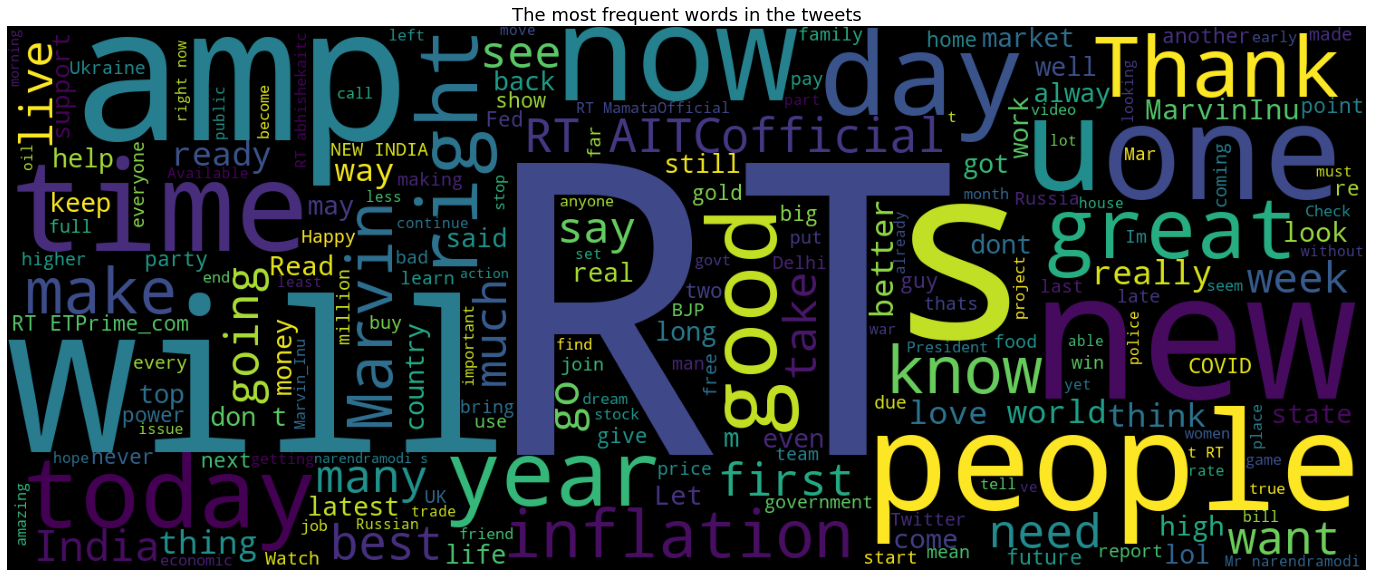

In [19]:
# Show mostly used words
plt.figure(figsize=(30,10))
plt.imshow(WordCloud(width=1500,height=600,stopwords=STOPWORDS).generate(' '.join(clean_df['clean_text'].values)))
plt.axis('off')
plt.title("The most frequent words in the tweets",fontsize=18)
plt.show()